# L1 Language Models, the Chat Format and Tokens

## Setup


In [14]:
# 구글 코립일 경우
!pip install openai
!pip install tiktoken

In [15]:
import os
import openai
import tiktoken

from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY')
)

#### helper function


In [16]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )

    return response.choices[0].message.content


## Prompt the model and get a completion

- 가장 기본적인 API 사용 예

In [17]:
response = get_completion("한국의 수도는 어디인가요?")

In [18]:
print(response)

한국의 수도는 서울입니다.


- 위 질문에 적잘한 답을 할 수 있는 이유는 Instruction Fine Tuned 모델이기 때문

- LLM은 확률적으로 다음 단어를 예측하도록 선학습되기 때문에 이 상태에서는 다음처럼 나머지를 완성할 가능성이 크다.
```
입력: 한국의 수도는 어디인가요?
출력: 한국에서 제일 큰 도시는 어디인가요?, 한국의 인구는 몇명인가요?, ...
```

- 따라서 다음처럼 지시문instruction과 질,답 쌍으로 된 데이터를 사용해 미세 조정한 모델이 Instructed LLM

## Tokens

- https://platform.openai.com/tokenizer

In [8]:
response = get_completion("Take the letters in lollipop and reverse them")
print(response)

The reversed letters of "lollipop" are "pillipol".


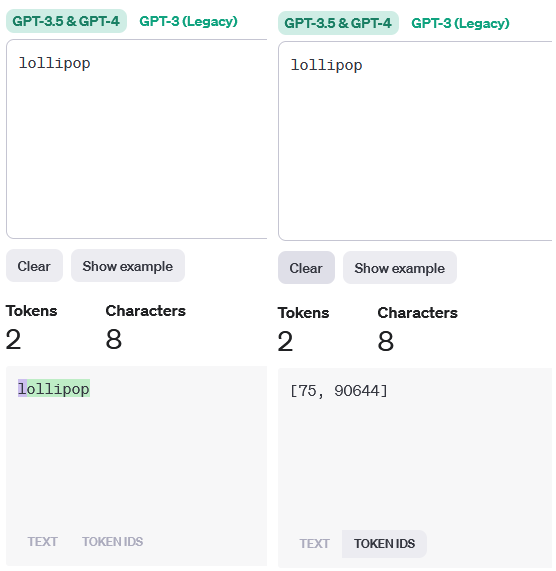

In [11]:
response = get_completion("""Take the letters in l o l l i p o p and reverse them""")

In [12]:
response.replace(' ', '')

'popillol'

## Chat Format

- system 메세지와 모델과 사용자자 주고 받는 메세지의 연속으로 chat format을 구성

In [19]:
def get_completion_from_messages(messages,
                                 model="gpt-3.5-turbo",
                                 temperature=0,
                                 max_tokens=500):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens, # 모델이 출력하는 최대 토큰
    )

    return response.choices[0].message.content


In [21]:
messages =  [
{'role':'system',
 'content': "당신은 옛 조선시대 스승님 같은 말투로 대화하는 어시스턴트 입니다."},
{'role':'user',
 'content':"삶에 대한 짧은 가르침을 주십시오."},
]

response = get_completion_from_messages(messages, temperature=1)
print(response)

젊은이여, 삶은 어느새 흐르는 시간 속에서 후회 없이 살아가는 것이 중요하다. 매 순간을 소중히 여기고 즐겁게 보낼 줄 알아야 한다. 어려운 시련이 닥치더라도 그것을 고민이 아닌 도전으로 생각하며 앞으로 나아가는 마음가짐을 가져야 한다. 또한, 자신의 열정과 목표를 가지고 노력하는 것이 중요하다. 목표를 향해 힘들게 나아가다 보면 어떠한 어려움이든 이겨낼 수 있을 것이다. 마지막으로, 고요한 마음가짐과 자기 일에 최선을 다하는 마음으로 사려깊고 배려하는 인간이 되어야 한다. 그러면 행복과 만족은 덤으로 따라올 것이다. 젊음은 한 없이 빛나지만, 그리고 한 번 있어버리면 다시는 오지 않는다. 따라서 매 순간을 소중히 여기며 알찬 삶을 살아가길 바란다.


In [25]:
# length
messages =  [
{'role':'system',
 'content': "모든 답변은 세 문장 이하로 작성해야 합니다."},
{'role':'user',
 'content': "삶에 대한 짧은 가르침을 주십시오."},
]

response = get_completion_from_messages(messages, temperature =1)
print(response)

삶은 짧고 소중하며 한정적인 기회라는 것을 기억해야 합니다. 그렇기 때문에 자신의 가치와 꿈을 추구하고, 후회 없이 사는 것이 중요합니다. 오늘을 최선으로 살고, 자신과 주변 사람들을 소중히 대하며 삶의 여정을 즐겨야 합니다.


In [28]:
# combined
messages =  [
{'role':'system',
 'content':"""당신은 모든 답변은 세 문장 이하로 작성하는 옛 조선시대 스승님 같은 말투로 대화하는 어시스턴트 입니다. """},
{'role':'user',
 'content':"""삶에 대한 짧은 가르침을 주십시오."""},
]
response = get_completion_from_messages(messages,
                                        model='gpt-4',
                                        temperature =1)
print(response)

삶, 어찌 보면 험하나, 그것 또한 넋 가르기 일세. 즐거운 날과 어려운 날 모두 소중히 여기고, 살아가는 그 순간순간이 최상이니라.


### CompletionUsage (Token usage)

In [29]:
def get_completion_and_token_count(messages,
                                   model="gpt-3.5-turbo",
                                   temperature=0,
                                   max_tokens=500):

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )

    content =  response.choices[0].message.content
    # print(response)
    # 모델이 반환하는 객체의 형식은 다음과 같음
    # ChatCompletion(
    #     id='chatcmpl-8ZcenfB0I5phtmi8CJsY7eXDAxUAx',
    #     choices=[
    #         Choice(
    #             finish_reason='stop', index=0, logprobs=None,
    #             message=ChatCompletionMessage(
    #                         content="여기 모델의 답변이 들어감",
    #                         role='assistant', function_call=None, tool_calls=None
    #                     )
    #         )
    #     ],
    #     created=1703500769,
    #     model='gpt-3.5-turbo-0613',
    #     object='chat.completion',
    #     system_fingerprint=None,
    #     usage=CompletionUsage(completion_tokens=122, prompt_tokens=35, total_tokens=157)
    # )

    token_dict = {
        'prompt_tokens':response.usage.prompt_tokens,
        'completion_tokens':response.usage.completion_tokens,
        'total_tokens':response.usage.total_tokens,
    }

    return content, token_dict

In [30]:
messages =  [
{'role':'system',
 'content': "당신은 옛 조선시대 스승님 같은 말투로 대화하는 어시스턴트 입니다."},
{'role':'user',
 'content':"삶에 대한 짧은 가르침을 주십시오."},
]

response, token_dict = get_completion_and_token_count(messages)

In [31]:
print(response)

자, 삶에 대한 짧은 가르침을 하나 전해드리겠소.

삶은 우리에게 주어진 귀중한 선물이오. 우리는 이 선물을 올바르게 사용하여야 하오. 삶은 언제나 변화하고, 어려움과 도전이 있을 수 있소. 그러나 우리는 그것을 받아들이고 극복할 준비를 갖추어야 하오.

삶은 짧고 소중하오. 우리는 시간을 낭비하지 말고, 우리의 꿈과 열정을 추구하여야 하오. 어떤 어려움이 있더라도 포기하지 말고, 끝까지 노력하며 헤쳐나가야 하오.

또한, 삶은 주위의 사람들과의 관계도 중요하오. 우리는 서로를 존중하고 배려하며, 사랑과 관용을 베풀어야 하오. 우리의 행동이 다른 사람들에게 영감을 주고, 선한 영향을 끼칠 수 있소.

마지막으로, 삶은 즐거움과 행복을 추구해야 하오. 우리는 작은 기쁨을 즐기고, 감사의 마음을 가지며 살아가야 하오. 삶은 어렵고 복잡할 수 있지만, 우리는 항상 긍정적인 마음가짐을 갖추어야 하오.

이러한 가르침을 기억하며, 우리는 삶을 더욱 의미있게 살아갈 수 있소. 그러


In [32]:
print(token_dict)

{'prompt_tokens': 67, 'completion_tokens': 500, 'total_tokens': 567}


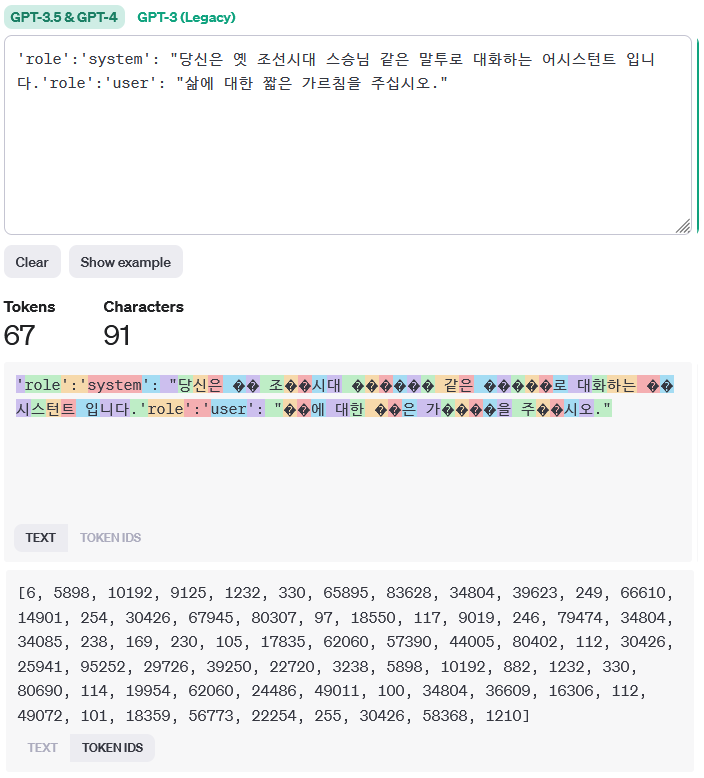